# Sentiment Analyse Wissenschaftlerinnen vs. Wissenschaftler

Verwendetes Modell: https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

Notebook als Hilfestellung: https://github.com/amanabdullayev/tutorials/blob/main/01%20VADER%20vs%20Transformers%20for%20sentiment/vader_vs_transformers.ipynb

In [2]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import re

2024-04-11 15:07:24.525749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Vorbereitung der Daten

In [3]:
tweets_wissenschaftler = pd.read_excel('./data/tweets_wissenschaftler.xlsx')
tweets_wissenschaftlerinnen = pd.read_excel('./data/tweets_wissenschaftlerinnen.xlsx')

In [4]:
def update_astype_tweets(df):
    df['tweet_text'] = df['tweet_text'].astype(str)
    df['tweet_text'] = df['tweet_text'].replace('-998', '')
    df['retweet_text_retweeted_tweet'] = df['retweet_text_retweeted_tweet'].astype(str)
    df['retweet_text_retweeted_tweet'] = df['retweet_text_retweeted_tweet'].replace('-998', '')
    df['zitat_text'] = df['zitat_text'].astype(str)
    df['zitat_text'] = df['zitat_text'].replace('-998', '')
    df['tweet_creator_bio'] = df['tweet_creator_bio'].astype(str)
    df['tweet_creator_bio'] = df['tweet_creator_bio'].replace('-998', '')
    df['tweet_creator_bio'] = df['tweet_creator_bio'].replace('nan', '')

In [5]:
update_astype_tweets(tweets_wissenschaftler)
update_astype_tweets(tweets_wissenschaftlerinnen)

In [6]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [7]:
for df in tweets_wissenschaftler, tweets_wissenschaftlerinnen:
    df['tweet_text'] = df['tweet_text'].apply(preprocess)
    df['retweet_text_retweeted_tweet'] = df['retweet_text_retweeted_tweet'].apply(preprocess)
    df['zitat_text'] = df['zitat_text'].apply(preprocess)
    df['tweet_creator_bio'] = df['tweet_creator_bio'].apply(preprocess)

### Durchführung der Sentiment Analysen

In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import torch
import torch.nn as nn

In [9]:
model_path = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

def sentiment_analyzer(text, model):
    if text.strip() == "":
        return None 
    else:
        encoded_input = tokenizer(text, return_tensors="pt")
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = np.round(softmax(scores), 2)
        scores_dict = {"neg": scores[0], "neu": scores[1], "pos": scores[2]}
        return scores_dict

In [10]:
tqdm.pandas() 

In [11]:
def get_sentiments(df, columns):
    for column in columns:
        df["probabilities"] = df[column].progress_apply(sentiment_analyzer, model=model)
        probabilities = df["probabilities"].apply(pd.Series)
        df = df.join(probabilities)
        df = df.drop("probabilities", axis=1)
    
        polarity_weights = torch.tensor([-1, 0, 1])
        probs = torch.tensor(df[["neg", "neu", "pos"]].values)
        polarity = polarity_weights * probs
        polarity = polarity.sum(dim=-1)
        polarity_scaled = nn.Tanh()(polarity)
    
        df[f"{column}_polarity"] = polarity_scaled.numpy()
        df[f"{column}_sentiment"] = pd.cut(df[f"{column}_polarity"],
                                     bins=[-1.0, -0.25, 0.25, 1.0],
                                     labels=["Negative", "Neutral", "Positive"],
                                    )
        df = df.drop(["neu", "neg", "pos"], axis=1)
    return df

In [12]:
tweets_wissenschaftler_sentiment = get_sentiments(tweets_wissenschaftler,['tweet_text','retweet_text_retweeted_tweet', 'zitat_text'])
tweets_wissenschaftler_sentiment.head()

100%|██████████| 1761/1761 [01:29<00:00, 19.57it/s]


,tweet_date_create,tweet_creator_atName,tweet_creator_screenName,tweet_creator_bio,tweet_text,retweet_text_retweeted_tweet,zitat_text,gender,institution,author_category,tweet_text_polarity,tweet_text_sentiment,retweet_text_retweeted_tweet_polarity,retweet_text_retweeted_tweet_sentiment,zitat_text_polarity,zitat_text_sentiment
0,2022-12-14 20:27:18,olewin,@olewin@mastodon.social 🇪🇺,Earthling of European origin. #Nachhaltigkeit ...,"Die Politikerin @user schätzt, dass wir in 10 ...",,Auch Deutschland habe Stärken in der Kernfusio...,männlich,Person,wissenschaftsnah,0.010000,Neutral,NaN,NaN,0.254296,Positive
1,2022-12-14 21:01:37,t3pad,Sonnen-τau (he/him),"Wer nur auf mein Gendern eingeht, hat offensic...",,Kernfusion ist keine Lösung in der Klimakrise ...,,männlich,Person,wissenschaftsnah,NaN,NaN,-0.139092,Neutral,NaN,NaN
2,2022-12-14 21:20:53,uehackler,U.E. Hackler🇩🇪🇯🇵🇺🇸,"Ph.D. in Chemistry, Languages: German, English...",,Der sensationelle Erfolg der USA bei der #Kern...,,männlich,Person,Wissenschaftler*in,NaN,NaN,0.413644,Positive,NaN,NaN
3,2022-12-14 21:28:53,agriachim,Achim Spiller,Professor Lebensmittel- u. Agrarmarketing Uni ...,Beide waren tolle Partner im Bioweiderindproje...,,Die Erzeugergemeinschaft Schwarzwald Bio-#Weid...,männlich,Person,Wissenschaftler*in,0.362707,Positive,NaN,NaN,0.069886,Neutral
4,2022-12-14 21:45:39,kommunikationsm,Rüdiger Frankenberger,Marketier I Lehrbeauftragter/Dozent I Berater ...,@user @user Welche Partei hat noch gleich die ...,,,männlich,Person,wissenschaftsnah,-0.089758,Neutral,NaN,NaN,NaN,NaN


In [13]:
tweets_wissenschaftlerinnen_sentiment = get_sentiments(tweets_wissenschaftlerinnen,['tweet_text','retweet_text_retweeted_tweet', 'zitat_text'])
tweets_wissenschaftlerinnen_sentiment.head()

100%|██████████| 1201/1201 [01:19<00:00, 15.12it/s]


,tweet_date_create,tweet_creator_atName,tweet_creator_screenName,tweet_creator_bio,tweet_text,retweet_text_retweeted_tweet,zitat_text,gender,institution,author_category,tweet_text_polarity,tweet_text_sentiment,retweet_text_retweeted_tweet_polarity,retweet_text_retweeted_tweet_sentiment,zitat_text_polarity,zitat_text_sentiment
0,2022-12-14 20:44:13,CorinnaEhlers,Corinna Ehlers (corinnaehlers@openbiblio.social),Grenzgängerin Theologie/Bibliothekswesen im FI...,,Forschungsstipendien an der Reformationsgeschi...,,weiblich,Person,Wissenschaftler*in,NaN,NaN,0.039979,Neutral,NaN,NaN
1,2022-12-15 06:42:28,A_SieberEgger,Anja Sieber Egger,Social und Cultural Anthropologist. Researcher...,,In der 5. Episode «Masken und Impfen» der #Pod...,,weiblich,Person,Wissenschaftler*in,NaN,NaN,0.019997,Neutral,NaN,NaN
2,2022-12-15 07:32:40,LeaZentgraf,Lea Loretta Zentgraf,"Sociologist at FU Berlin, focus on feminist an...",,Heute stellen wir Ximena Alba Villalever und @...,,weiblich,Person,Wissenschaftler*in,NaN,NaN,0.059928,Neutral,NaN,NaN
3,2022-12-15 08:09:44,LauVoAlb,Laura von Albedyhll,"Forschende, lehrende Kindheitspädagogin | PH W...",,Mareike Trauernicht hat den 2. Preis der Körbe...,,weiblich,Person,Wissenschaftler*in,NaN,NaN,0.158648,Neutral,NaN,NaN
4,2022-12-15 08:12:55,7Me11y7,7Me11y7-@7Me11y7@nerdculture.de,"Dr. rer. nat., Psychologie Rationalität und Wi...",@user @user Ich finde diese Grafik nicht gelun...,,,weiblich,Person,wissenschaftsnah,-0.58498,Negative,NaN,NaN,NaN,NaN


In [14]:
tweets_wissenschaftler_sentiment.to_excel('./sentiment_data/tweets_wissenschaftler_sentiment.xlsx')
tweets_wissenschaftlerinnen_sentiment.to_excel('./sentiment_data/tweets_wissenschaftlerinnen_sentiment.xlsx')

### Gegenüberstellung der Ergebnisse

In [1]:
import pandas as pd

In [2]:
tweets_wissenschaftler_sentiment = pd.read_excel('./sentiment_data/tweets_wissenschaftler_sentiment.xlsx')
tweets_wissenschaftlerinnen_sentiment = pd.read_excel('./sentiment_data/tweets_wissenschaftlerinnen_sentiment.xlsx')

In [3]:
# Definieren der Spalten, die Sentiment-Daten enthalten
sentiment_columns = ['tweet_text_sentiment', 'retweet_text_retweeted_tweet_sentiment', 'zitat_text_sentiment']

#### Überblick Ergebnisse - Wissenschaftler

In [4]:
value_counts = []
percentages = []
for column in sentiment_columns:
    vc = tweets_wissenschaftler_sentiment[column].value_counts()
    pct = vc / vc.sum() * 100  # Optimiert: Verwende vc zur Berechnung von pct
    value_counts.append(vc)
    percentages.append(pct.round(2))  # Runden direkt nach der Berechnung

# DataFrames aus den Value Counts und Prozenten
counts_wissenschaftler = pd.DataFrame(value_counts)
percentages_wissenschaftler = pd.DataFrame(percentages)

# Setzen der Indizes
counts_wissenschaftler.index = percentages_wissenschaftler.index = sentiment_columns

# Hinzufügen der 'all_tweets' Zeile zur Zusammenfassung über alle Tweets
counts_wissenschaftler.loc['all_tweets'] = counts_wissenschaftler.sum()
percentages_wissenschaftler.loc['all_tweets'] = (counts_wissenschaftler.loc['all_tweets'] / counts_wissenschaftler.loc['all_tweets'].sum() * 100).round(2)

In [5]:
counts_wissenschaftler

,Negative,Neutral,Positive
tweet_text_sentiment,362,341,175
retweet_text_retweeted_tweet_sentiment,231,404,248
zitat_text_sentiment,74,204,86
all_tweets,667,949,509


In [6]:
percentages_wissenschaftler

,Negative,Neutral,Positive
tweet_text_sentiment,41.23,38.84,19.93
retweet_text_retweeted_tweet_sentiment,26.16,45.75,28.09
zitat_text_sentiment,20.33,56.04,23.63
all_tweets,31.39,44.66,23.95


#### Überblick Ergebnisse - Wissenschaftlerinnen

In [7]:
value_counts = []
percentages = []
for column in sentiment_columns:
    vc = tweets_wissenschaftlerinnen_sentiment[column].value_counts()
    pct = vc / vc.sum() * 100  # Optimiert: Verwende vc zur Berechnung von pct
    value_counts.append(vc)
    percentages.append(pct.round(2))  # Runden direkt nach der Berechnung

# DataFrames aus den Value Counts und Prozenten
counts_wissenschaftlerinnen = pd.DataFrame(value_counts)
percentages_wissenschaftlerinnen = pd.DataFrame(percentages)

# Setzen der Indizes
counts_wissenschaftlerinnen.index = percentages_wissenschaftlerinnen.index = sentiment_columns

# Hinzufügen der 'all_tweets' Zeile zur Zusammenfassung über alle Tweets
counts_wissenschaftlerinnen.loc['all_tweets'] = counts_wissenschaftlerinnen.sum()
percentages_wissenschaftlerinnen.loc['all_tweets'] = (counts_wissenschaftlerinnen.loc['all_tweets'] / counts_wissenschaftlerinnen.loc['all_tweets'].sum() * 100).round(2)

In [44]:
#Reihenfolge Spalten ändern
counts_wissenschaftlerinnen = counts_wissenschaftlerinnen[['Negative', 'Neutral', 'Positive']]
percentages_wissenschaftlerinnen = percentages_wissenschaftlerinnen[['Negative', 'Neutral', 'Positive']]

In [45]:
counts_wissenschaftlerinnen

,Negative,Neutral,Positive
tweet_text_sentiment,142,184,151
retweet_text_retweeted_tweet_sentiment,202,336,186
zitat_text_sentiment,61,205,72
all_tweets,405,725,409


In [46]:
percentages_wissenschaftlerinnen

,Negative,Neutral,Positive
tweet_text_sentiment,29.77,38.57,31.66
retweet_text_retweeted_tweet_sentiment,27.90,46.41,25.69
zitat_text_sentiment,18.05,60.65,21.30
all_tweets,26.32,47.11,26.58


#### Analyse über Zeitverlauf

##### Wissenschaftler

In [15]:
df = tweets_wissenschaftler_sentiment.copy()

# Datum in datetime umwandeln und Jahr-Monat extrahieren
df['tweet_date_create'] = pd.to_datetime(df['tweet_date_create'])
df['year_week'] = df['tweet_date_create'].dt.to_period('W')

# Alle Sentiments in einer einzigen Spalte zusammenführen
all_sentiments = pd.concat([
    df['tweet_text_sentiment'],
    df['retweet_text_retweeted_tweet_sentiment'],
    df['zitat_text_sentiment']
], ignore_index=True)

# Zugehörige Datumswerte für die zusammengeführten Sentiments wiederholen
dates = pd.concat([df['year_week']] * 3, ignore_index=True)

# Neuen DataFrame erstellen für die Analyse
combined = pd.DataFrame({
    'year_week': dates,
    'sentiment': all_sentiments
})

# Sentiments nach Jahr und Monat gruppieren und zählen
weekly_sentiment_wissenschaftler_counts = combined.groupby(['year_week', 'sentiment']).size().unstack(fill_value=0)

# Format der Wochenbezeichnung anpassen: 'KWxx, yyyy'
weekly_sentiment_wissenschaftler_counts.index = weekly_sentiment_wissenschaftler_counts.index.to_series().apply(lambda x: f'KW{x.week}/ {x.start_time.year}')

# Prozentuale Anteile berechnen
weekly_sentiment_wissenschaftler_percentages  = weekly_sentiment_wissenschaftler_counts .div(weekly_sentiment_wissenschaftler_counts .sum(axis=1), axis=0) * 100

In [16]:
weekly_sentiment_wissenschaftler_counts

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,46,63,36
KW51/ 2022,37,64,63
KW52/ 2022,54,51,20
KW1/ 2023,72,89,70
KW2/ 2023,145,160,66
KW3/ 2023,72,125,47
KW4/ 2023,82,118,58
KW5/ 2023,106,162,81
KW6/ 2023,53,117,68


In [17]:
weekly_sentiment_wissenschaftler_percentages

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,31.724138,43.448276,24.827586
KW51/ 2022,22.560976,39.024390,38.414634
KW52/ 2022,43.200000,40.800000,16.000000
KW1/ 2023,31.168831,38.528139,30.303030
KW2/ 2023,39.083558,43.126685,17.789757
KW3/ 2023,29.508197,51.229508,19.262295
KW4/ 2023,31.782946,45.736434,22.480620
KW5/ 2023,30.372493,46.418338,23.209169
KW6/ 2023,22.268908,49.159664,28.571429


##### Wissenschaftlerinnen

In [18]:
df = tweets_wissenschaftlerinnen_sentiment.copy()

# Datum in datetime umwandeln und Jahr-Monat extrahieren
df['tweet_date_create'] = pd.to_datetime(df['tweet_date_create'])
df['year_week'] = df['tweet_date_create'].dt.to_period('W')

# Alle Sentiments in einer einzigen Spalte zusammenführen
all_sentiments = pd.concat([
    df['tweet_text_sentiment'],
    df['retweet_text_retweeted_tweet_sentiment'],
    df['zitat_text_sentiment']
], ignore_index=True)

# Zugehörige Datumswerte für die zusammengeführten Sentiments wiederholen
dates = pd.concat([df['year_week']] * 3, ignore_index=True)

# Neuen DataFrame erstellen für die Analyse
combined = pd.DataFrame({
    'year_week': dates,
    'sentiment': all_sentiments
})

# Sentiments nach Jahr und Monat gruppieren und zählen
weekly_sentiment_wissenschaftlerinnen_counts = combined.groupby(['year_week', 'sentiment']).size().unstack(fill_value=0)

# Format der Wochenbezeichnung anpassen: 'KWxx, yyyy'
weekly_sentiment_wissenschaftlerinnen_counts.index = weekly_sentiment_wissenschaftlerinnen_counts.index.to_series().apply(lambda x: f'KW{x.week}/ {x.start_time.year}')

# Prozentuale Anteile berechnen
weekly_sentiment_wissenschaftlerinnen_percentages  = weekly_sentiment_wissenschaftlerinnen_counts .div(weekly_sentiment_wissenschaftlerinnen_counts .sum(axis=1), axis=0) * 100

In [19]:
weekly_sentiment_wissenschaftlerinnen_counts

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,36,57,35
KW51/ 2022,24,60,34
KW52/ 2022,21,28,15
KW1/ 2023,26,65,34
KW2/ 2023,70,95,51
KW3/ 2023,63,108,53
KW4/ 2023,64,81,57
KW5/ 2023,64,103,62
KW6/ 2023,37,127,68


In [20]:
# Letze Zeile entfernen wegen zu geringer Anzahl
weekly_sentiment_wissenschaftlerinnen_counts = weekly_sentiment_wissenschaftlerinnen_counts.drop(['KW7/ 2023'], axis=0)
weekly_sentiment_wissenschaftlerinnen_percentages = weekly_sentiment_wissenschaftlerinnen_percentages.drop(['KW7/ 2023'], axis=0)

In [21]:
weekly_sentiment_wissenschaftlerinnen_counts

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,36,57,35
KW51/ 2022,24,60,34
KW52/ 2022,21,28,15
KW1/ 2023,26,65,34
KW2/ 2023,70,95,51
KW3/ 2023,63,108,53
KW4/ 2023,64,81,57
KW5/ 2023,64,103,62
KW6/ 2023,37,127,68


In [22]:
weekly_sentiment_wissenschaftlerinnen_percentages

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,28.125000,44.531250,27.343750
KW51/ 2022,20.338983,50.847458,28.813559
KW52/ 2022,32.812500,43.750000,23.437500
KW1/ 2023,20.800000,52.000000,27.200000
KW2/ 2023,32.407407,43.981481,23.611111
KW3/ 2023,28.125000,48.214286,23.660714
KW4/ 2023,31.683168,40.099010,28.217822
KW5/ 2023,27.947598,44.978166,27.074236
KW6/ 2023,15.948276,54.741379,29.310345


#### Visualisieren der Ergebnisse

In [41]:
import matplotlib.pyplot as plt
colors = ['firebrick','bisque','forestgreen']

##### Sentiment Verteilungen

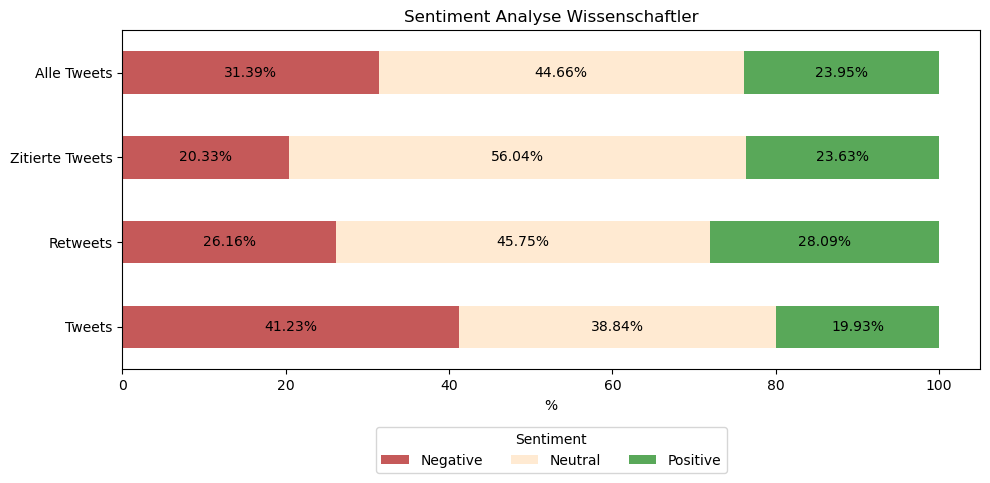

In [47]:
# Gestapeltes Balkendiagramm erstellen
ax = percentages_wissenschaftler.plot(kind='barh', stacked=True, figsize=(10, 5), color=colors, alpha=0.75)
ax.set_xlabel('%')
ax.set_title('Sentiment Analyse Wissenschaftler')
ax.set_yticklabels(['Tweets','Retweets','Zitierte Tweets', 'Alle Tweets'])

# Balkenbeschriftungen hinzufügen
for n in ax.patches:
    left, bottom, width, height = n.get_bbox().bounds
    ax.annotate(f"{width:.2f}%", xy=(left+width/2, bottom+height/2), 
                ha='center', va='center', fontsize=10, color='black')
    
plt.legend(title='Sentiment', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

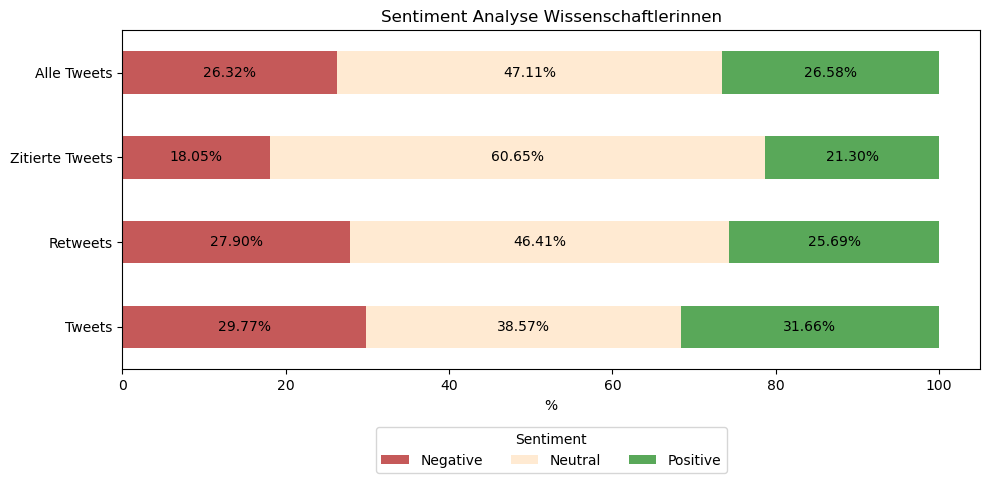

In [48]:
# Gestapeltes Balkendiagramm erstellen
ax = percentages_wissenschaftlerinnen.plot(kind='barh', stacked=True, figsize=(10, 5), color=colors, alpha=0.75)
ax.set_xlabel('%')
ax.set_title('Sentiment Analyse Wissenschaftlerinnen')
ax.set_yticklabels(['Tweets','Retweets','Zitierte Tweets', 'Alle Tweets'])

# Balkenbeschriftungen hinzufügen
for n in ax.patches:
    left, bottom, width, height = n.get_bbox().bounds
    ax.annotate(f"{width:.2f}%", xy=(left+width/2, bottom+height/2), 
                ha='center', va='center', fontsize=10, color='black')
    
plt.legend(title='Sentiment', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

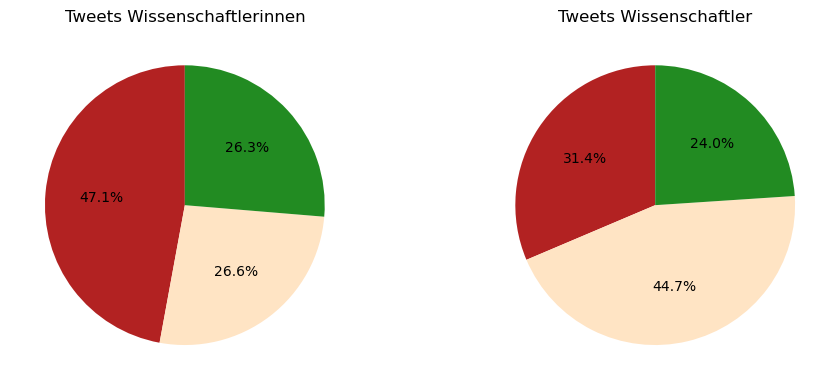

In [14]:
# Erstellen der Plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  # Zwei Plots nebeneinander

# Erstes Kreisdiagramm
axes[0].pie(counts_wissenschaftlerinnen.loc['all_tweets'], autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Tweets Wissenschaftlerinnen')

# Zweites Kreisdiagramm
axes[1].pie(counts_wissenschaftler.loc['all_tweets'], autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Tweets Wissenschaftler')

# Anzeigen der Plots
#plt.legend(labels = row.index, title='Sentiment', bbox_to_anchor=(0.5, -0.15), loc=8, ncol=3)
plt.tight_layout() 
plt.show()

##### Zeitlicher Verlauf

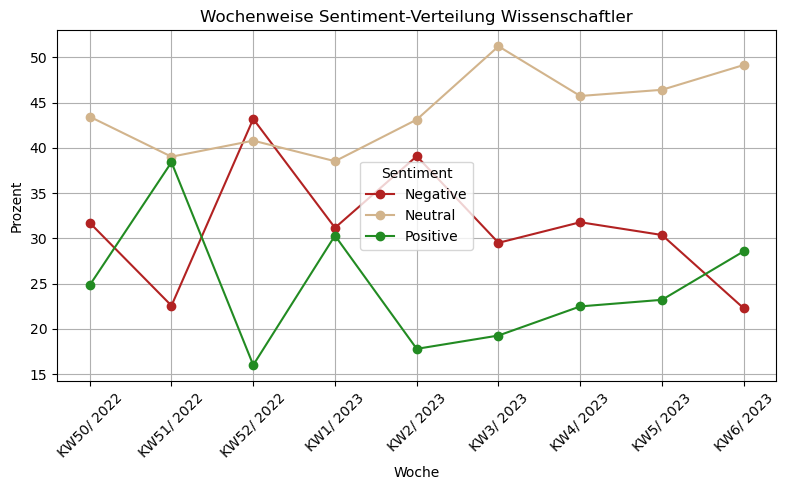

In [62]:
# Liniendiagramm der Sentiment-Verteilung pro Woche für Datensatz Wissenschaftler
colors = ['firebrick','tan','forestgreen']
weekly_sentiment_wissenschaftler_percentages.plot(kind='line', marker='o', figsize=(8, 5), color=colors)
plt.title('Wochenweise Sentiment-Verteilung Wissenschaftler')
plt.xlabel('Woche')
plt.ylabel('Prozent')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.legend(title='Sentiment')
plt.show()

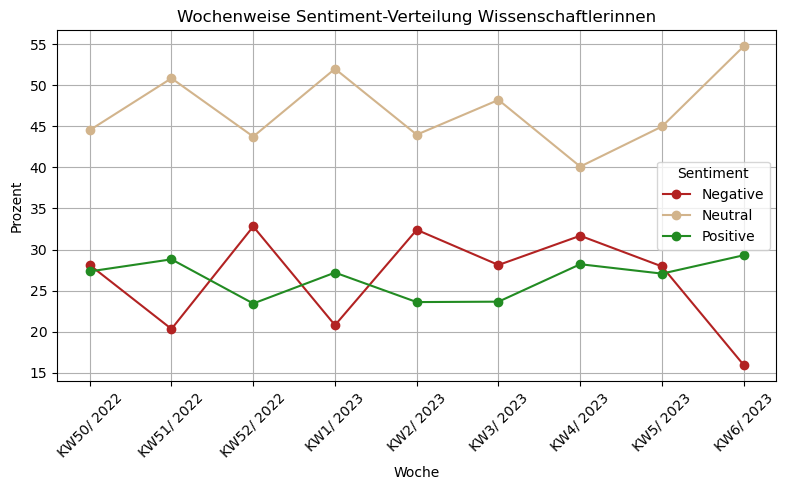

In [63]:
# Liniendiagramm der Sentiment-Verteilung pro Woche für Datensatz Wissenschaftlerinnen
weekly_sentiment_wissenschaftlerinnen_percentages.plot(kind='line', marker='o', figsize=(8, 5), color=colors)
plt.title('Wochenweise Sentiment-Verteilung Wissenschaftlerinnen')
plt.xlabel('Woche')
plt.ylabel('Prozent')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.legend(title='Sentiment')
plt.show()

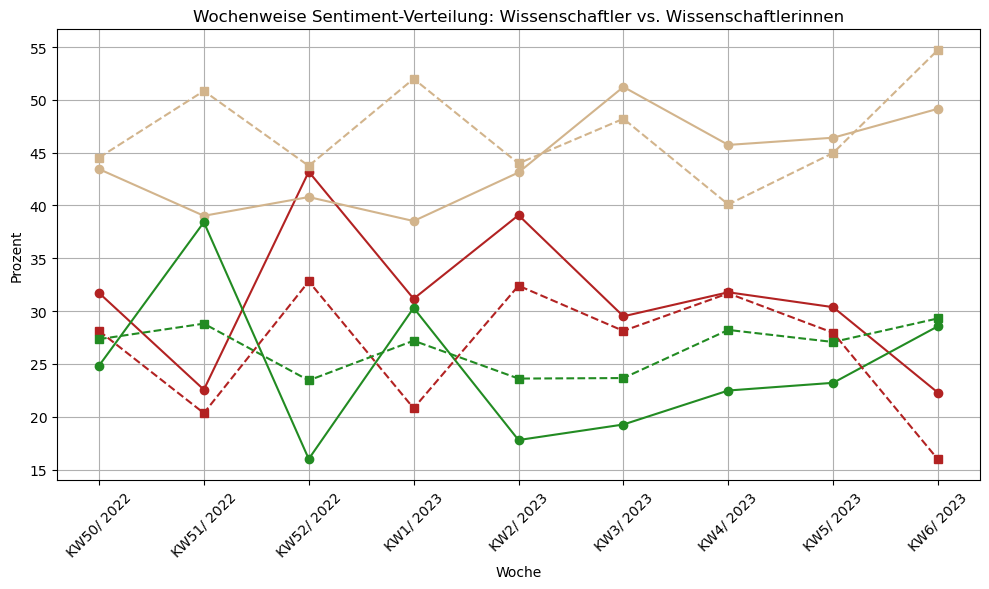

In [61]:
# Farben und Plot
colors = ['firebrick', 'tan', 'forestgreen']
weekly_sentiment_wissenschaftler_percentages.plot(kind='line', marker='o', figsize=(10, 6), color=colors)
weekly_sentiment_wissenschaftlerinnen_percentages.plot(kind='line', style='--', marker='s',color=colors, ax=plt.gca())

plt.title('Wochenweise Sentiment-Verteilung: Wissenschaftler vs. Wissenschaftlerinnen')
plt.xlabel('Woche')
plt.ylabel('Prozent')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend().set_visible(False)
plt.show()

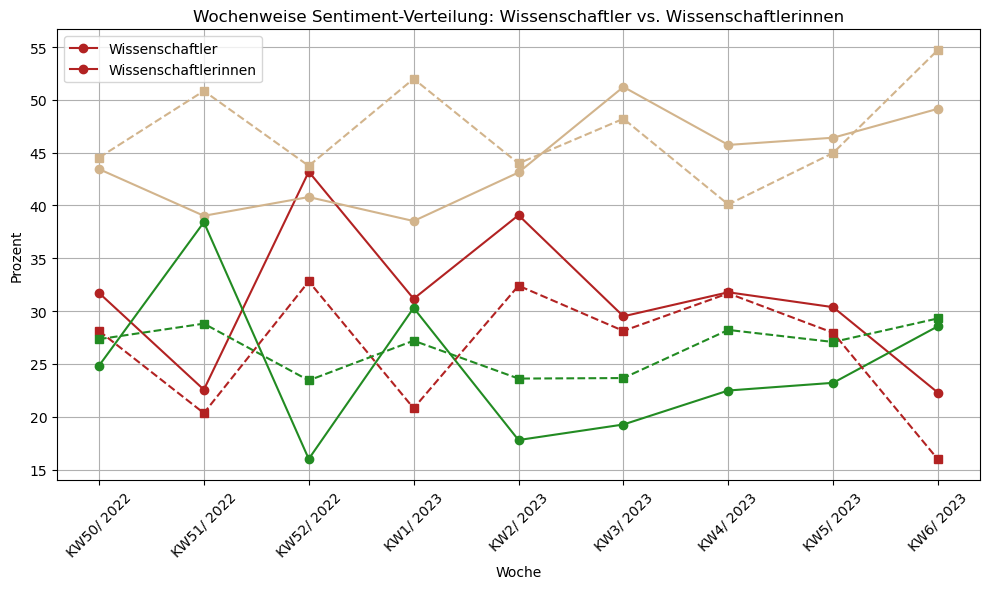

In [70]:
line_scientists = weekly_sentiment_wissenschaftler_percentages.plot(kind='line', marker='o', figsize=(10, 6), color=colors)
line_scientist_females = weekly_sentiment_wissenschaftlerinnen_percentages.plot(kind='line', style='--', marker='s', color=colors, ax=plt.gca())

plt.title('Wochenweise Sentiment-Verteilung: Wissenschaftler vs. Wissenschaftlerinnen')
plt.xlabel('Woche')
plt.ylabel('Prozent')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Legende erstellen
lines = [line_scientists.lines[0], line_scientist_females.lines[0]]
labels = ['Wissenschaftler', 'Wissenschaftlerinnen']
plt.legend(lines, labels)
plt.show()